In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define a Convolutional Block
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out

# Define a Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        # Add skip connection if input and output channels differ
        self.shortcut = nn.Sequential()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm2d(out_channels)
            )
        
    def forward(self, x):
        residual = self.shortcut(x)
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        out = F.relu(out)
        return out

# Define an Upsampling Block
class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpConv, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        
    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        return x

# Define the ResUNet Model
class ResUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(ResUNet, self).__init__()
        
        # Encoder
        self.enc1 = ConvBlock(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = ResidualBlock(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = ConvBlock(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = ResidualBlock(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        
        # Bridge
        self.bridge = ConvBlock(512, 1024)
        
        # Decoder
        self.dec4 = UpConv(1024, 512)
        self.dec4_conv = ResidualBlock(1024, 512)
        self.dec3 = UpConv(512, 256)
        self.dec3_conv = ConvBlock(512, 256)
        self.dec2 = UpConv(256, 128)
        self.dec2_conv = ResidualBlock(256, 128)
        self.dec1 = UpConv(128, 64)
        self.dec1_conv = ConvBlock(128, 64)
        
        # Output
        self.final = nn.Sequential(
            nn.Conv2d(64, out_channels, kernel_size=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool1(enc1))
        enc3 = self.enc3(self.pool2(enc2))
        enc4 = self.enc4(self.pool3(enc3))
        
        # Bridge
        bridge = self.bridge(self.pool4(enc4))
        
        # Decoder
        dec4 = self.dec4(bridge, enc4)
        dec4 = self.dec4_conv(dec4)
        dec3 = self.dec3(dec4, enc3)
        dec3 = self.dec3_conv(dec3)
        dec2 = self.dec2(dec3, enc2)
        dec2 = self.dec2_conv(dec2)
        dec1 = self.dec1(dec2, enc1)
        dec1 = self.dec1_conv(dec1)
        
        # Output
        return self.final(dec1)


Using device: cuda
Loading data...


100%|██████████| 110/110 [00:02<00:00, 37.07it/s]


Train: 2751, Validation: 589, Test: 589


Epoch 1/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.65it/s]


Epoch 1/100 - Train Loss: 0.4451, Train Dice Loss: 0.9564, Val Loss: 0.4206, Val Dice Loss: 0.9431
Saved best model with validation loss: 0.4206


Epoch 2/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 16.13it/s]


Epoch 2/100 - Train Loss: 0.4051, Train Dice Loss: 0.9175, Val Loss: 0.3998, Val Dice Loss: 0.9078
Saved best model with validation loss: 0.3998


Epoch 3/100 (Validation): 100%|██████████| 74/74 [00:06<00:00, 10.85it/s]


Epoch 3/100 - Train Loss: 0.3783, Train Dice Loss: 0.8746, Val Loss: 0.3616, Val Dice Loss: 0.8438
Saved best model with validation loss: 0.3616


Epoch 4/100 (Validation): 100%|██████████| 74/74 [00:06<00:00, 10.82it/s]


Epoch 4/100 - Train Loss: 0.3448, Train Dice Loss: 0.8092, Val Loss: 0.3244, Val Dice Loss: 0.7693
Saved best model with validation loss: 0.3244


Epoch 5/100 (Validation): 100%|██████████| 74/74 [00:06<00:00, 11.66it/s]


Epoch 5/100 - Train Loss: 0.3063, Train Dice Loss: 0.7223, Val Loss: 0.3071, Val Dice Loss: 0.7332
Saved best model with validation loss: 0.3071


Epoch 6/100 (Validation): 100%|██████████| 74/74 [00:05<00:00, 13.47it/s]


Epoch 6/100 - Train Loss: 0.2601, Train Dice Loss: 0.6138, Val Loss: 0.2310, Val Dice Loss: 0.5502
Saved best model with validation loss: 0.2310


Epoch 7/100 (Validation): 100%|██████████| 74/74 [00:05<00:00, 12.61it/s]


Epoch 7/100 - Train Loss: 0.2097, Train Dice Loss: 0.4914, Val Loss: 0.2278, Val Dice Loss: 0.5379
Saved best model with validation loss: 0.2278


Epoch 8/100 (Validation): 100%|██████████| 74/74 [00:06<00:00, 10.93it/s]


Epoch 8/100 - Train Loss: 0.1860, Train Dice Loss: 0.4308, Val Loss: 0.1842, Val Dice Loss: 0.4267
Saved best model with validation loss: 0.1842


Epoch 9/100 (Validation): 100%|██████████| 74/74 [00:14<00:00,  5.18it/s]


Epoch 9/100 - Train Loss: 0.1749, Train Dice Loss: 0.4014, Val Loss: 0.2133, Val Dice Loss: 0.4948
EarlyStopping counter: 1 out of 10


Epoch 10/100 (Validation): 100%|██████████| 74/74 [00:09<00:00,  7.48it/s]


Epoch 10/100 - Train Loss: 0.1587, Train Dice Loss: 0.3621, Val Loss: 0.1506, Val Dice Loss: 0.3504
Saved best model with validation loss: 0.1506


Epoch 11/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.63it/s]


Epoch 11/100 - Train Loss: 0.1464, Train Dice Loss: 0.3328, Val Loss: 0.1352, Val Dice Loss: 0.3134
Saved best model with validation loss: 0.1352


Epoch 12/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.74it/s]


Epoch 12/100 - Train Loss: 0.1258, Train Dice Loss: 0.2852, Val Loss: 0.1395, Val Dice Loss: 0.3182
EarlyStopping counter: 1 out of 10


Epoch 13/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.69it/s]


Epoch 13/100 - Train Loss: 0.1297, Train Dice Loss: 0.2924, Val Loss: 0.1420, Val Dice Loss: 0.3297
EarlyStopping counter: 2 out of 10


Epoch 14/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.76it/s]


Epoch 14/100 - Train Loss: 0.1252, Train Dice Loss: 0.2810, Val Loss: 0.1205, Val Dice Loss: 0.2762
Saved best model with validation loss: 0.1205


Epoch 15/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.72it/s]


Epoch 15/100 - Train Loss: 0.1221, Train Dice Loss: 0.2742, Val Loss: 0.1195, Val Dice Loss: 0.2716
Saved best model with validation loss: 0.1195


Epoch 16/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.73it/s]


Epoch 16/100 - Train Loss: 0.1155, Train Dice Loss: 0.2598, Val Loss: 0.1424, Val Dice Loss: 0.3264
EarlyStopping counter: 1 out of 10


Epoch 17/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.69it/s]


Epoch 17/100 - Train Loss: 0.1109, Train Dice Loss: 0.2483, Val Loss: 0.1216, Val Dice Loss: 0.2823
EarlyStopping counter: 2 out of 10


Epoch 18/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.69it/s]


Epoch 18/100 - Train Loss: 0.1086, Train Dice Loss: 0.2431, Val Loss: 0.1493, Val Dice Loss: 0.3415
EarlyStopping counter: 3 out of 10


Epoch 19/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.66it/s]


Epoch 19/100 - Train Loss: 0.1047, Train Dice Loss: 0.2342, Val Loss: 0.1084, Val Dice Loss: 0.2484
Saved best model with validation loss: 0.1084


Epoch 20/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.71it/s]


Epoch 20/100 - Train Loss: 0.1022, Train Dice Loss: 0.2297, Val Loss: 0.1383, Val Dice Loss: 0.3187
EarlyStopping counter: 1 out of 10


Epoch 21/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.69it/s]


Epoch 21/100 - Train Loss: 0.0986, Train Dice Loss: 0.2200, Val Loss: 0.1106, Val Dice Loss: 0.2536
EarlyStopping counter: 2 out of 10


Epoch 22/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.69it/s]


Epoch 22/100 - Train Loss: 0.0956, Train Dice Loss: 0.2132, Val Loss: 0.1168, Val Dice Loss: 0.2684
EarlyStopping counter: 3 out of 10


Epoch 23/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.71it/s]


Epoch 23/100 - Train Loss: 0.1070, Train Dice Loss: 0.2394, Val Loss: 0.1120, Val Dice Loss: 0.2553
EarlyStopping counter: 4 out of 10


Epoch 24/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.71it/s]


Epoch 24/100 - Train Loss: 0.0956, Train Dice Loss: 0.2131, Val Loss: 0.1041, Val Dice Loss: 0.2364
Saved best model with validation loss: 0.1041


Epoch 25/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.74it/s]


Epoch 25/100 - Train Loss: 0.0871, Train Dice Loss: 0.1938, Val Loss: 0.1105, Val Dice Loss: 0.2503
EarlyStopping counter: 1 out of 10


Epoch 26/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.71it/s]


Epoch 26/100 - Train Loss: 0.0994, Train Dice Loss: 0.2224, Val Loss: 0.1314, Val Dice Loss: 0.3025
EarlyStopping counter: 2 out of 10


Epoch 27/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.70it/s]


Epoch 27/100 - Train Loss: 0.1053, Train Dice Loss: 0.2343, Val Loss: 0.1053, Val Dice Loss: 0.2399
EarlyStopping counter: 3 out of 10


Epoch 28/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.70it/s]


Epoch 28/100 - Train Loss: 0.0913, Train Dice Loss: 0.2046, Val Loss: 0.0980, Val Dice Loss: 0.2237
Saved best model with validation loss: 0.0980


Epoch 29/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.76it/s]


Epoch 29/100 - Train Loss: 0.0899, Train Dice Loss: 0.1999, Val Loss: 0.0985, Val Dice Loss: 0.2263
EarlyStopping counter: 1 out of 10


Epoch 30/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.73it/s]


Epoch 30/100 - Train Loss: 0.0833, Train Dice Loss: 0.1856, Val Loss: 0.0939, Val Dice Loss: 0.2149
Saved best model with validation loss: 0.0939


Epoch 31/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.68it/s]


Epoch 31/100 - Train Loss: 0.0867, Train Dice Loss: 0.1931, Val Loss: 0.1048, Val Dice Loss: 0.2394
EarlyStopping counter: 1 out of 10


Epoch 32/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.63it/s]


Epoch 32/100 - Train Loss: 0.0835, Train Dice Loss: 0.1847, Val Loss: 0.0951, Val Dice Loss: 0.2147
EarlyStopping counter: 2 out of 10


Epoch 33/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.68it/s]


Epoch 33/100 - Train Loss: 0.1025, Train Dice Loss: 0.2301, Val Loss: 0.1479, Val Dice Loss: 0.3397
EarlyStopping counter: 3 out of 10


Epoch 34/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.68it/s]


Epoch 34/100 - Train Loss: 0.0967, Train Dice Loss: 0.2160, Val Loss: 0.1025, Val Dice Loss: 0.2336
EarlyStopping counter: 4 out of 10


Epoch 35/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.69it/s]


Epoch 35/100 - Train Loss: 0.0842, Train Dice Loss: 0.1879, Val Loss: 0.0934, Val Dice Loss: 0.2115
Saved best model with validation loss: 0.0934


Epoch 36/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.51it/s]


Epoch 36/100 - Train Loss: 0.0862, Train Dice Loss: 0.1922, Val Loss: 0.0909, Val Dice Loss: 0.2094
Saved best model with validation loss: 0.0909


Epoch 37/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.51it/s]


Epoch 37/100 - Train Loss: 0.0830, Train Dice Loss: 0.1858, Val Loss: 0.0852, Val Dice Loss: 0.1926
Saved best model with validation loss: 0.0852


Epoch 38/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.77it/s]


Epoch 38/100 - Train Loss: 0.0816, Train Dice Loss: 0.1813, Val Loss: 0.0991, Val Dice Loss: 0.2253
EarlyStopping counter: 1 out of 10


Epoch 39/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.71it/s]


Epoch 39/100 - Train Loss: 0.0765, Train Dice Loss: 0.1711, Val Loss: 0.0959, Val Dice Loss: 0.2204
EarlyStopping counter: 2 out of 10


Epoch 40/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.67it/s]


Epoch 40/100 - Train Loss: 0.0778, Train Dice Loss: 0.1732, Val Loss: 0.0891, Val Dice Loss: 0.2025
EarlyStopping counter: 3 out of 10


Epoch 41/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.72it/s]


Epoch 41/100 - Train Loss: 0.0809, Train Dice Loss: 0.1817, Val Loss: 0.1020, Val Dice Loss: 0.2309
EarlyStopping counter: 4 out of 10


Epoch 42/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.66it/s]


Epoch 42/100 - Train Loss: 0.0748, Train Dice Loss: 0.1668, Val Loss: 0.1218, Val Dice Loss: 0.2806
EarlyStopping counter: 5 out of 10


Epoch 43/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.61it/s]


Epoch 43/100 - Train Loss: 0.0769, Train Dice Loss: 0.1704, Val Loss: 0.0877, Val Dice Loss: 0.1990
EarlyStopping counter: 6 out of 10


Epoch 44/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.63it/s]


Epoch 44/100 - Train Loss: 0.0820, Train Dice Loss: 0.1829, Val Loss: 0.0894, Val Dice Loss: 0.2032
EarlyStopping counter: 7 out of 10


Epoch 45/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.68it/s]


Epoch 45/100 - Train Loss: 0.0777, Train Dice Loss: 0.1718, Val Loss: 0.0905, Val Dice Loss: 0.2043
EarlyStopping counter: 8 out of 10


Epoch 46/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.72it/s]


Epoch 46/100 - Train Loss: 0.0809, Train Dice Loss: 0.1810, Val Loss: 0.1128, Val Dice Loss: 0.2554
EarlyStopping counter: 9 out of 10


Epoch 47/100 (Validation): 100%|██████████| 74/74 [00:04<00:00, 17.49it/s]


Epoch 47/100 - Train Loss: 0.0818, Train Dice Loss: 0.1837, Val Loss: 0.0986, Val Dice Loss: 0.2230
EarlyStopping counter: 10 out of 10
Early stopping triggered


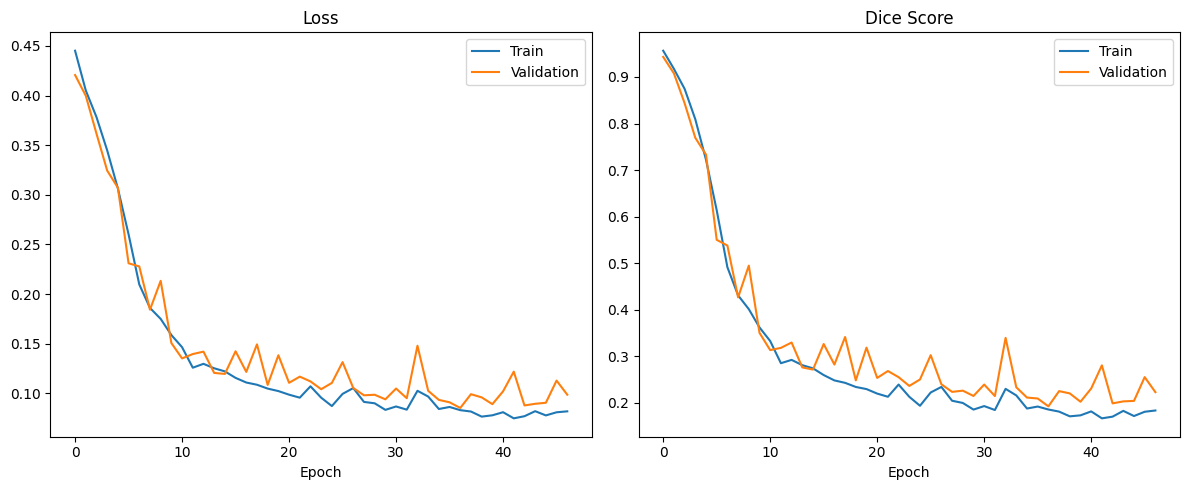

Evaluating: 100%|██████████| 589/589 [00:03<00:00, 152.40it/s]


Test Dice Score: 0.8818


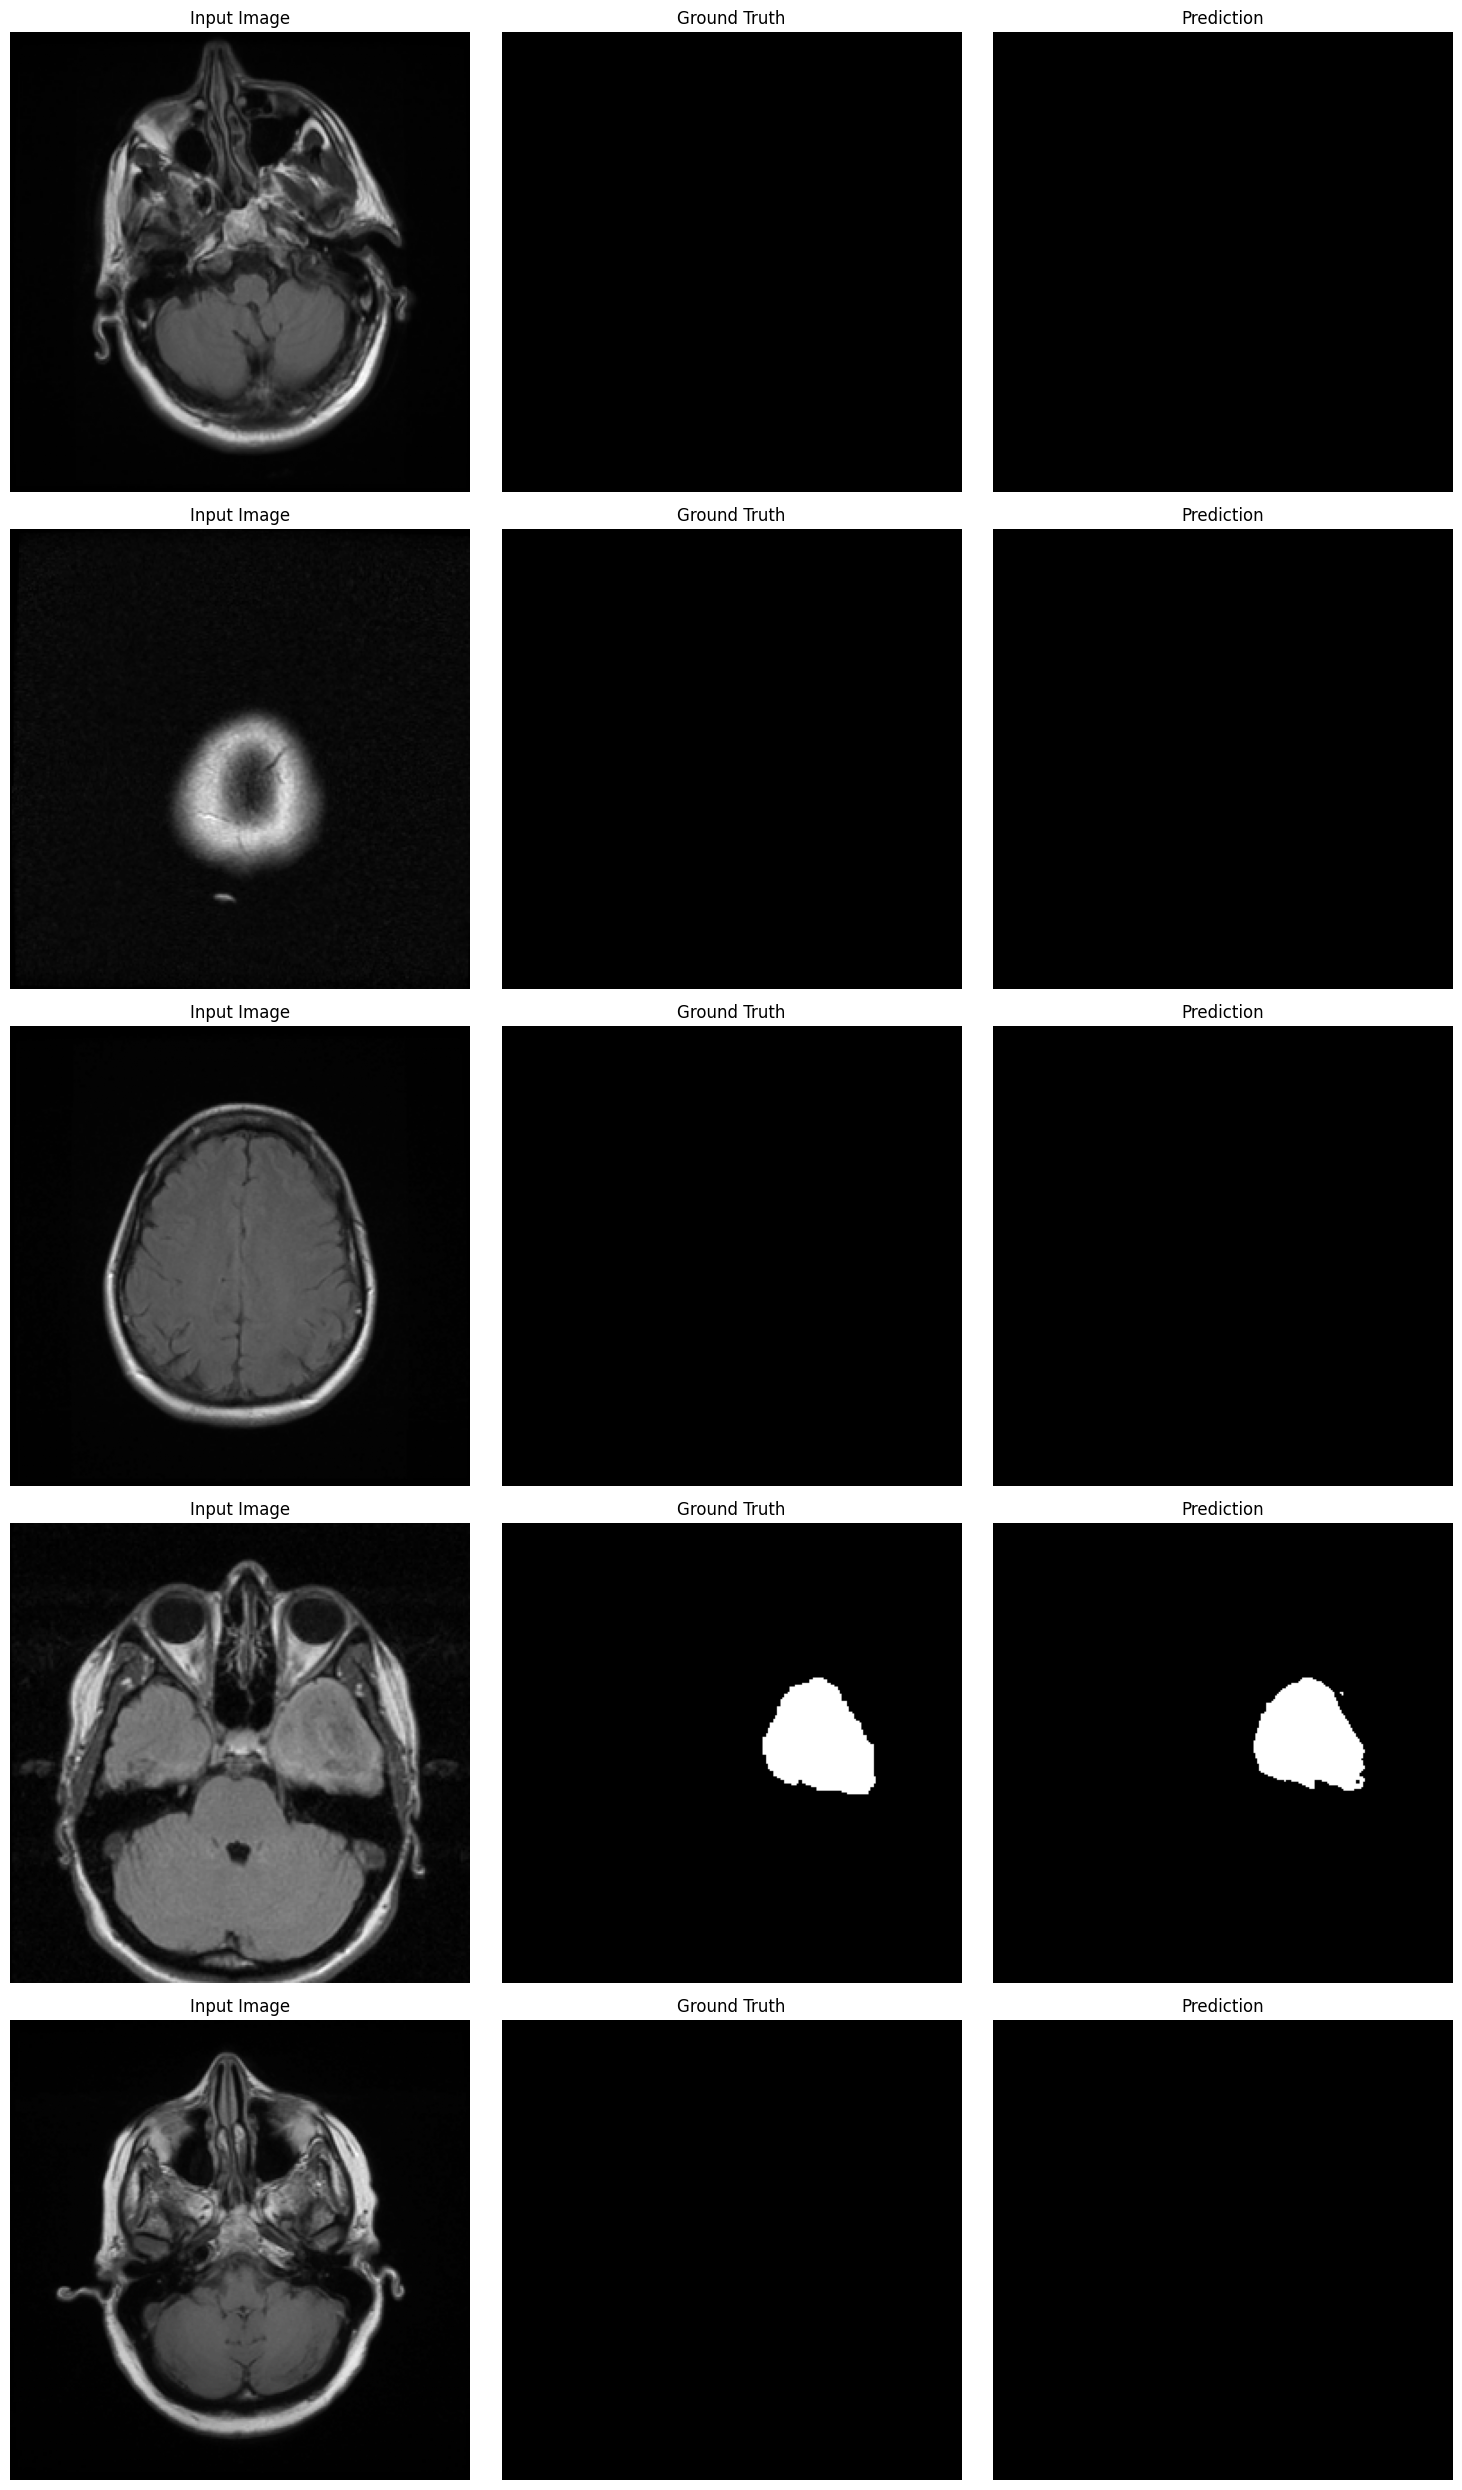

In [2]:
from segmentation import run_segmentation_pipeline

# # Define your custom U-Net or any segmentation model here
# class MyCustomUNet(nn.Module):
#     def __init__(self, in_channels=1, out_channels=1):
#         super(MyCustomUNet, self).__init__()
#         # Define your custom architecture here
#         # ...

#     def forward(self, x):
#         # Define the forward pass
#         # ...
#         return output

# Create your model instance
my_model = ResUNet(in_channels=1, out_channels=1)

# Run the pipeline with custom model and naming
trained_model, dice_score = run_segmentation_pipeline(
    model=my_model,
    base_dir="kaggle_3m",
    model_name="Best_ResUnet",
    batch_size=8,
    patience=10
)